# Optimizing Camera Distance for Aircraft Position Observation and Calculation

## 1. Problem Definition

![1](2.png)

In this problem, we have three main points:
- O₁, O₂: positions of two cameras
- M: aircraft position

The goal is to find the appropriate distance between two cameras for efficient observation and calculation of aircraft position.

Notation:
- d: distance between two cameras (O₁O₂)
- h: aircraft altitude
- $r_{1,2}$: distance from camera(1,2) to aircraft
- w: contrail width
- p: number of pixels displaying contrail
- φ: angle between camera-aircraft line and horizontal plane (in degrees)
- R: camera horizontal resolution
- α: camera vertical field of view (VFOV)



## 2. Analysis of Influencing Factors

### 2.1. Effect of Camera Distance on Contrail Pixel Display

When d is large, r will also be large. This results in smaller contrail images, reducing the number of pixels used to display the contrail.

Formula for calculating pixels across contrail width:

$$p = (w/r) * (R/(2*tan(α/2)))$$


Where:
- w = 200-400m (according to [FAA](https://www.faa.gov/sites/faa.gov/files/regulations_policies/policy_guidance/envir_policy/contrails.pdf))
- Reason for choosing w = 200m: We are more concerned with old contrails that have existed for some time and spread. Choosing the minimum value of 200m helps examine the most challenging case.
- R = 3840 (4K camera)
- α = 67.3°

Example with φ = 60° and h = 12000m:

$$
r = 13856m
p = (200/13856) * (3840/(2*tan(67.3/2)))
  ≈ 0.0144 * 2880
  ≈ 42 pixels
$$

### 2.2. Effect of Camera Distance on Height Calculation Accuracy

When d is small, angles φ₁ and φ₂ will be large. Height is calculated using the formula:
$$
h = M₁H * tan(φ₁) = M₂H * tan(φ₂)
$$

When φ > 70°, the tan(x) function curve increases very rapidly:

![3](3.png)



## 3. Reasons for Choosing h = 12km

1. This is the maximum altitude at which aircraft typically fly
2. At this altitude:
   - The angle between camera and aircraft will be maximum
   - Distance r will be longest
3. If the system works well at this altitude, it will work well at lower altitudes



## 4. Case Comparisons

Here, we test with $\phi_1$ and $ \phi_2 $ less than $ 70^\circ $ to avoid significant error impact, but not too small to prevent the distance between the aircraft and the two cameras from becoming too large, which would reduce the number of pixels representing the contrail. We consider three cases here with $\phi_1 = \phi_2 = \phi \in \{60^\circ, 65^\circ, 70^\circ\} $.

### 4.1. With φ = 60°:
- $r = h/sin(60°) ≈ 13856 $ m
- $p = (200/13856) * (3840/(2*tan(67.3/2))) ≈ 42$ pixels
- $d = 2 * h * cos(60°)/sin(60°) ≈ 13856$ m

### 4.2. With φ = 65°:
- $r = h/sin(65°) ≈ 13235$ m
- $p = (200/13235) * (3840/(2*tan(67.3/2))) ≈ 44$ pixels
- $d = 2 * h * cos(65°)/sin(65°) ≈ 11191$ m

### 4.3. With φ = 70°:
- $r = h/sin(70°) ≈ 12779$ m
- $p = (200/12779) * (3840/(2*tan(67.3/2))) ≈ 45$ pixels
- $d = 2 * h * cos(70°)/sin(70°) ≈ 8736$ m



## 5. Results Summary Table

| Angle φ | Distance d (m) | Pixels p |
|---------|---------------|----------|
| 60°     | 13856         | 42       |
| 65°     | 11191         | 44       |
| 70°     | 8736          | 45       |



## 6. Conclusion

From the above table, we can observe:
1. Increasing d => increases r, leading to decreased p
2. Decreasing d => increases φ, potentially causing large errors when φ > 70°

To balance between pixel display and error potential, we choose φ = 65°. At this angle:
- p = 44 pixels: sufficient for effective contrail analysis
- φ is small enough to limit errors in height calculation
- d ≈ 11191m: reasonable distance for practical deployment



In [8]:
import math
import numpy as np

def calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2):
    R = 6371000  # Bán kính Trái Đất tính bằng mét

    # Chuyển đổi độ sang radian
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    # Khoảng cách trên mặt đất
    ground_distance = R * c

    # Tính khoảng cách trong không gian 3D
    height_diff = alt2 - alt1
    distance = math.sqrt(ground_distance**2 + height_diff**2)
    return distance

def calculate_angles(pixel, resolution, hfov, vfov, tilt_angle):
    hfov_rad = math.radians(hfov)
    vfov_rad = math.radians(vfov)
    tilt_angle_rad = math.radians(tilt_angle)

    # Calculate alpha angle (horizontal)
    alpha = -math.atan((pixel[0] - resolution[0]/2) / (resolution[0]/2) * math.tan(hfov_rad/2))

    # Calculate beta angle (vertical)
    beta = tilt_angle_rad + math.atan((pixel[1] - resolution[1]/2) / (resolution[1]/2) * math.tan(vfov_rad/2))

    return alpha, beta

def calculate_direction_vector(alpha, beta, is_camera2=False):
    if not is_camera2:
        costhetax = math.sqrt(1 - math.sin(alpha)**2 - math.sin(beta)**2)
        costhetay = math.sin(alpha)
        costhetaz = math.sin(beta)
    else:
        costhetax = -math.sqrt(1 - math.sin(alpha)**2 - math.sin(beta)**2)
        costhetay = -math.sin(alpha)
        costhetaz = math.sin(beta)
    
    return np.array([costhetax, costhetay, costhetaz])

def find_closest_point(P1, P2, M1, M2):
    v = P2 - P1
    t = np.dot(np.cross(v, M2), np.cross(M1, M2)) / np.linalg.norm(np.cross(M1, M2))**2
    s = np.dot(np.cross(v, M1), np.cross(M1, M2)) / np.linalg.norm(np.cross(M1, M2))**2
    
    Pc1 = P1 + t * M1
    Pc2 = P2 + s * M2
    
    return (Pc1 + Pc2) / 2

def calculate_aircraft_position(lat1, lon1, alt1, lat2, lon2, alt2, pixel1, pixel2, resolution1, resolution2, hfov1, vfov1, hfov2, vfov2, tilt_angle1, tilt_angle2):
    # Tính khoảng cách giữa hai camera
    D = calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2)

    # Thiết lập vị trí camera cho tính toán, bao gồm cả độ cao
    camera1_pos = np.array([0, 0, alt1])
    camera2_pos = np.array([D, 0, alt2])

    # Tính các góc alpha và beta cho cả hai camera
    alpha1, beta1 = calculate_angles(pixel1, resolution1, hfov1, vfov1, tilt_angle1)
    alpha2, beta2 = calculate_angles(pixel2, resolution2, hfov2, vfov2, tilt_angle2)

    # Tính vector hướng cho cả hai camera
    M1 = calculate_direction_vector(alpha1, beta1)
    M2 = calculate_direction_vector(alpha2, beta2, is_camera2=True)

    # Tìm điểm gần nhất (vị trí máy bay)
    aircraft_position = find_closest_point(camera1_pos, camera2_pos, M1, M2)

    # Chiều cao của máy bay chính là tọa độ z của aircraft_position
    aircraft_height = aircraft_position[2]

    # Tính khoảng cách từ điểm ảnh đến từng camera
    distance_to_camera1 = np.linalg.norm(aircraft_position - camera1_pos)
    distance_to_camera2 = np.linalg.norm(aircraft_position - camera2_pos)

    return D, aircraft_height, aircraft_position, M1, M2, alpha1, alpha2, beta1, beta2, distance_to_camera1, distance_to_camera2, camera1_pos, camera2_pos

# Sử dụng hàm
lat1, lon1, alt1 = 21.028511, 105.804817, 1000  # Tọa độ và độ cao camera 1
lat2, lon2, alt2 = 21.028511, 105.904817, 1000  # Tọa độ và độ cao camera 2
pixel1 = (1920, 2160)
pixel2 = (3840, 4320)
resolution1 = (3840, 2160)
resolution2 = (7680, 4320)
hfov1, vfov1 = 53.06, 67.3
hfov2, vfov2 = 53.06, 67.3
tilt_angle1 = 35
tilt_angle2 = 35

D, aircraft_height, aircraft_position, M1, M2, alpha1, alpha2, beta1, beta2, distance_to_camera1, distance_to_camera2, camera1_pos, camera2_pos = calculate_aircraft_position(
    lat1, lon1, alt1, lat2, lon2, alt2, pixel1, pixel2, resolution1, resolution2, hfov1, vfov1, hfov2, vfov2, tilt_angle1, tilt_angle2)

print(f"Khoảng cách giữa hai camera: {D:.2f} meters")
print(f"Chiều cao của máy bay: {aircraft_height:.2f} meters")
print(f"Góc giữa đường thẳng nối cam 1 và điểm ảnh với XOZ (Alpha1): {math.degrees(alpha1):.2f} degrees")
print(f"Vị trí máy bay (tuyệt đối): ({aircraft_position[0]:.2f}, {aircraft_position[1]:.2f}, {aircraft_position[2]:.2f}) meters")
print(f"Khoảng cách từ điểm ảnh đến camera 1: {distance_to_camera1:.2f} meters")
print(f"Khoảng cách từ điểm ảnh đến camera 2: {distance_to_camera2:.2f} meters")
print(f"Alpha2 (degrees): {math.degrees(alpha2):.2f}")
print(f"Beta1 (degrees): {math.degrees(beta1):.2f}")
print(f"Beta2 (degrees): {math.degrees(beta2):.2f}")
print(f"Direction vector M1: ({M1[0]:.4f}, {M1[1]:.4f}, {M1[2]:.4f})")
print(f"Direction vector M2: ({M2[0]:.4f}, {M2[1]:.4f}, {M2[2]:.4f})")
print(f"Camera 1 position: ({camera1_pos[0]:.2f}, {camera1_pos[1]:.2f}, {camera1_pos[2]:.2f}) meters")
print(f"Camera 2 position: ({camera2_pos[0]:.2f}, {camera2_pos[1]:.2f}, {camera2_pos[2]:.2f}) meters")


Khoảng cách giữa hai camera: 10378.96 meters
Chiều cao của máy bay: 14276.08 meters
Góc giữa đường thẳng nối cam 1 và điểm ảnh với XOZ (Alpha1): -0.00 degrees
Vị trí máy bay (tuyệt đối): (5189.48, 0.00, 14276.08) meters
Khoảng cách từ điểm ảnh đến camera 1: 14254.30 meters
Khoảng cách từ điểm ảnh đến camera 2: 14254.30 meters
Alpha2 (degrees): -0.00
Beta1 (degrees): 68.65
Beta2 (degrees): 68.65
Direction vector M1: (0.3641, -0.0000, 0.9314)
Direction vector M2: (-0.3641, 0.0000, 0.9314)
Camera 1 position: (0.00, 0.00, 1000.00) meters
Camera 2 position: (10378.96, 0.00, 1000.00) meters


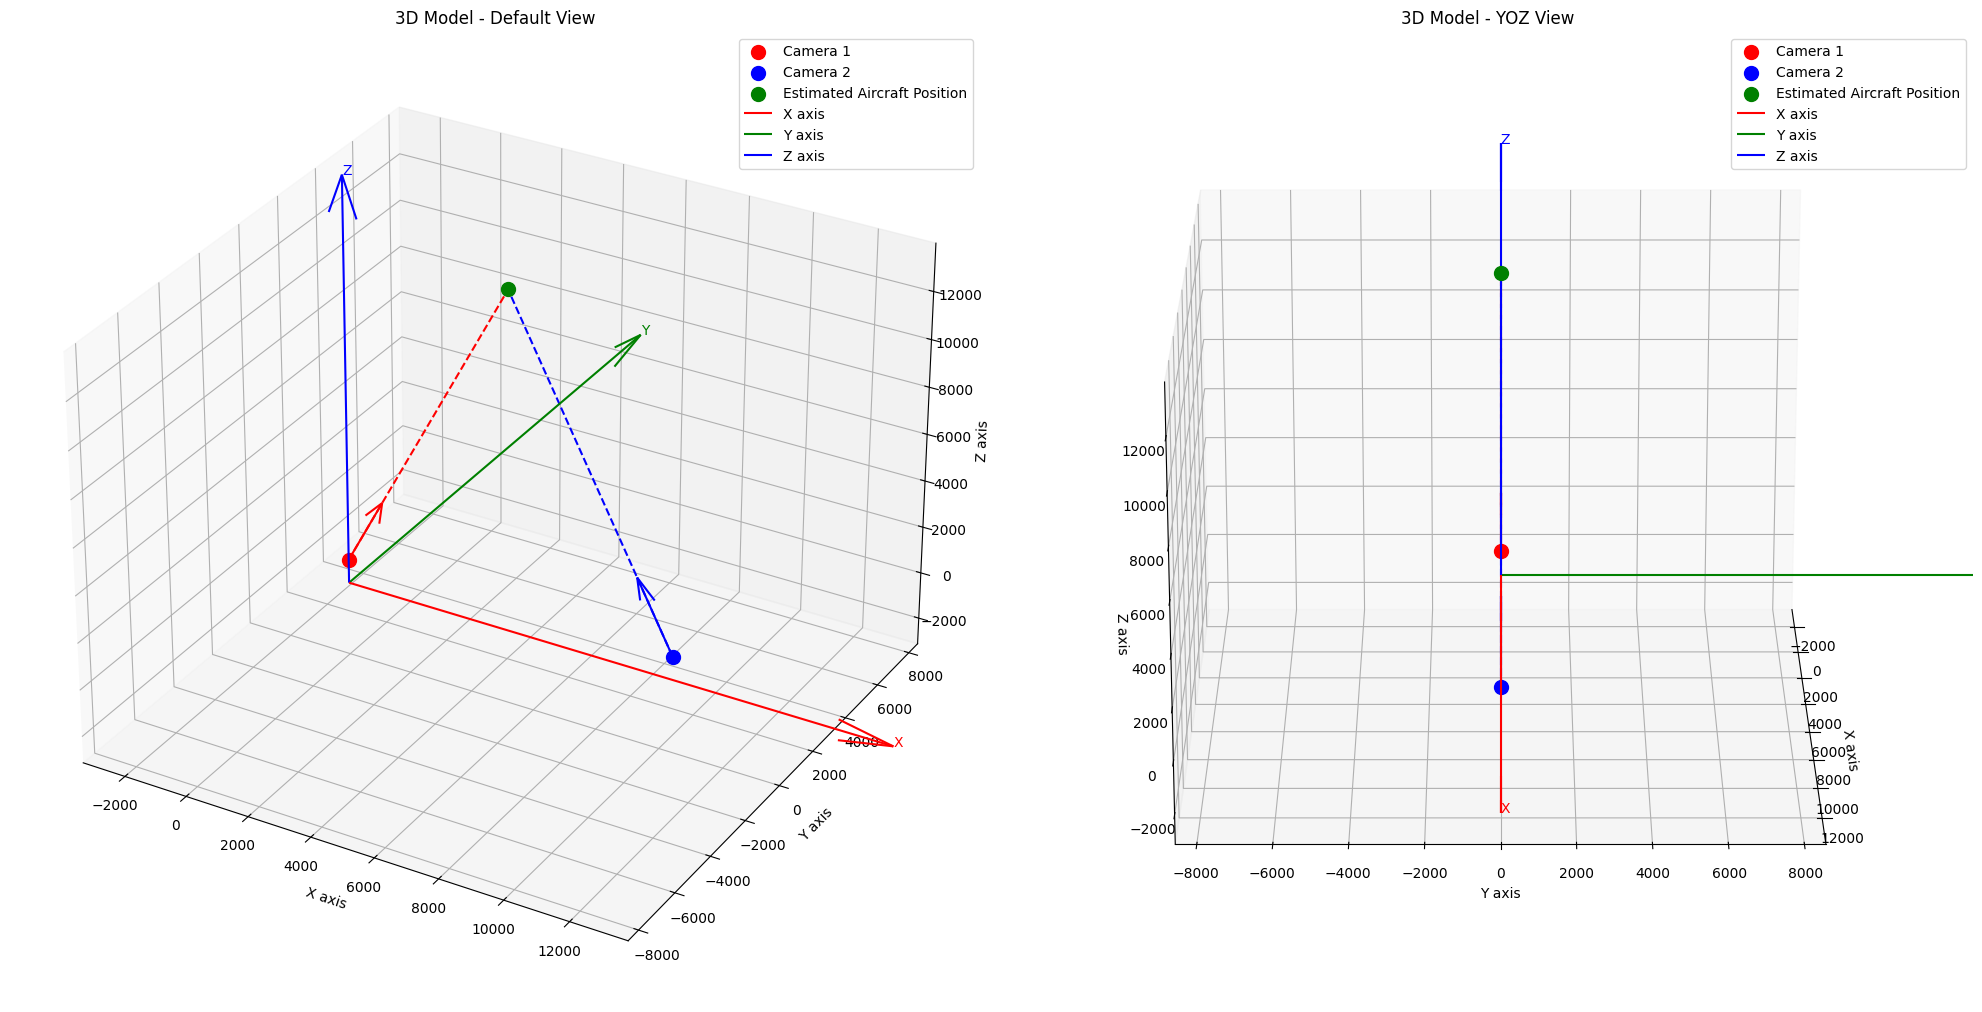

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_model(D, aircraft_position, M1, M2, camera1_pos, camera2_pos):
    fig = plt.figure(figsize=(20, 10))
    
    # Subplot 1: Default view
    ax1 = fig.add_subplot(121, projection='3d')
    plot_subplot(ax1, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, "Default View")
    
    # Subplot 2: YOZ view
    ax2 = fig.add_subplot(122, projection='3d')
    plot_subplot(ax2, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, "YOZ View")
    ax2.view_init(elev=20, azim=0)
    
    plt.tight_layout()
    plt.show()

def plot_subplot(ax, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, view_title):
    # Set scale factor based on camera distance
    scale = D * 0.3  # You can adjust this multiplier to change the relative length

    # Plot cameras
    ax.scatter(*camera1_pos, color='r', s=100, label='Camera 1')
    ax.scatter(*camera2_pos, color='b', s=100, label='Camera 2')

    # Plot camera direction vectors
    ax.quiver(*camera1_pos, *(M1 * scale), color='r')
    ax.quiver(*camera2_pos, *(M2 * scale), color='b')

    # Plot estimated aircraft position
    ax.scatter(*aircraft_position, color='g', s=100, label='Estimated Aircraft Position')

    # Connect cameras to aircraft position
    ax.plot([camera1_pos[0], aircraft_position[0]], 
            [camera1_pos[1], aircraft_position[1]], 
            [camera1_pos[2], aircraft_position[2]], 'r--')
    ax.plot([camera2_pos[0], aircraft_position[0]], 
            [camera2_pos[1], aircraft_position[1]], 
            [camera2_pos[2], aircraft_position[2]], 'b--')

    # Add coordinate axes
    origin = [0, 0, 0]
    axis_length = max(np.max(np.abs(aircraft_position)), D, 
                      np.max(np.abs(camera1_pos)), np.max(np.abs(camera2_pos))) * 1.2
    ax.quiver(*origin, axis_length, 0, 0, color='r', arrow_length_ratio=0.1, label='X axis')
    ax.quiver(*origin, 0, axis_length, 0, color='g', arrow_length_ratio=0.1, label='Y axis')
    ax.quiver(*origin, 0, 0, axis_length, color='b', arrow_length_ratio=0.1, label='Z axis')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(f'3D Model - {view_title}')

    # Set axis limits
    max_range = np.array([camera1_pos, camera2_pos, aircraft_position, 
                          [axis_length, axis_length, axis_length]]).ptp(axis=0).max() / 2.0
    mid_x = (camera1_pos[0] + camera2_pos[0]) / 2
    mid_y = (camera1_pos[1] + camera2_pos[1] + aircraft_position[1]) / 3
    mid_z = (camera1_pos[2] + camera2_pos[2] + aircraft_position[2]) / 3
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Add text labels for axes
    ax.text(axis_length, 0, 0, "X", color='red')
    ax.text(0, axis_length, 0, "Y", color='green')
    ax.text(0, 0, axis_length, "Z", color='blue')

    ax.legend()

# Sử dụng hàm với dữ liệu từ tính toán trước đó
plot_3d_model(D, aircraft_position, M1, M2, camera1_pos, camera2_pos)
